In [382]:
import numpy as np
import pandas as pd
import seaborn as sns

import fiona
import shapely
import rasterio
from rasterio.io import MemoryFile
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import Window

from skimage.filters import gaussian, threshold_mean
from skimage.exposure import equalize_adapthist, equalize_hist

from scipy.interpolate import spline
from scipy.stats import pearsonr

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import scale
from sklearn.metrics.cluster import silhouette_score

import matplotlib.colors as clr
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [186]:
%matplotlib notebook

In [187]:
BANDS = [461, 480, 490, 502, 516, 526, 540, 554, 555, 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

BANDS_L = [461, 480, 490, 502, 516, 526, 540, 554, ' ', 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

In [ ]:
shapefile = fiona.open("../data/shapes/reprojected/pp_2_trees_geometry.shp", "r")

## Read with Shapefile

In [259]:
shp_bounds = shapefile.bounds

bounds = {'type': 'Polygon', 'coordinates': [[(shp_bounds[0],shp_bounds[1]), (shp_bounds[0],shp_bounds[3]),
                                              (shp_bounds[2],shp_bounds[3]), (shp_bounds[2],shp_bounds[1])]]}

In [5]:
with rasterio.open("../data/hyperspectral/flight_07/Reflectance__dcube.bil") as src:
    out_image, out_transform = mask(src, [bounds], crop=True)
    out_meta = src.meta.copy()
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with MemoryFile() as mem_file:
    dst = mem_file.open(**out_meta)
    dst.write(out_image)

## Simple Reading

In [361]:
with rasterio.open("../data/hyperspectral/flight_07/Reflectance__dcube_clipped.tif") as src:
    out_image = src.read()
    out_meta = src.meta.copy()

# Crowns Delineation

/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


<IPython.core.display.Javascript object>


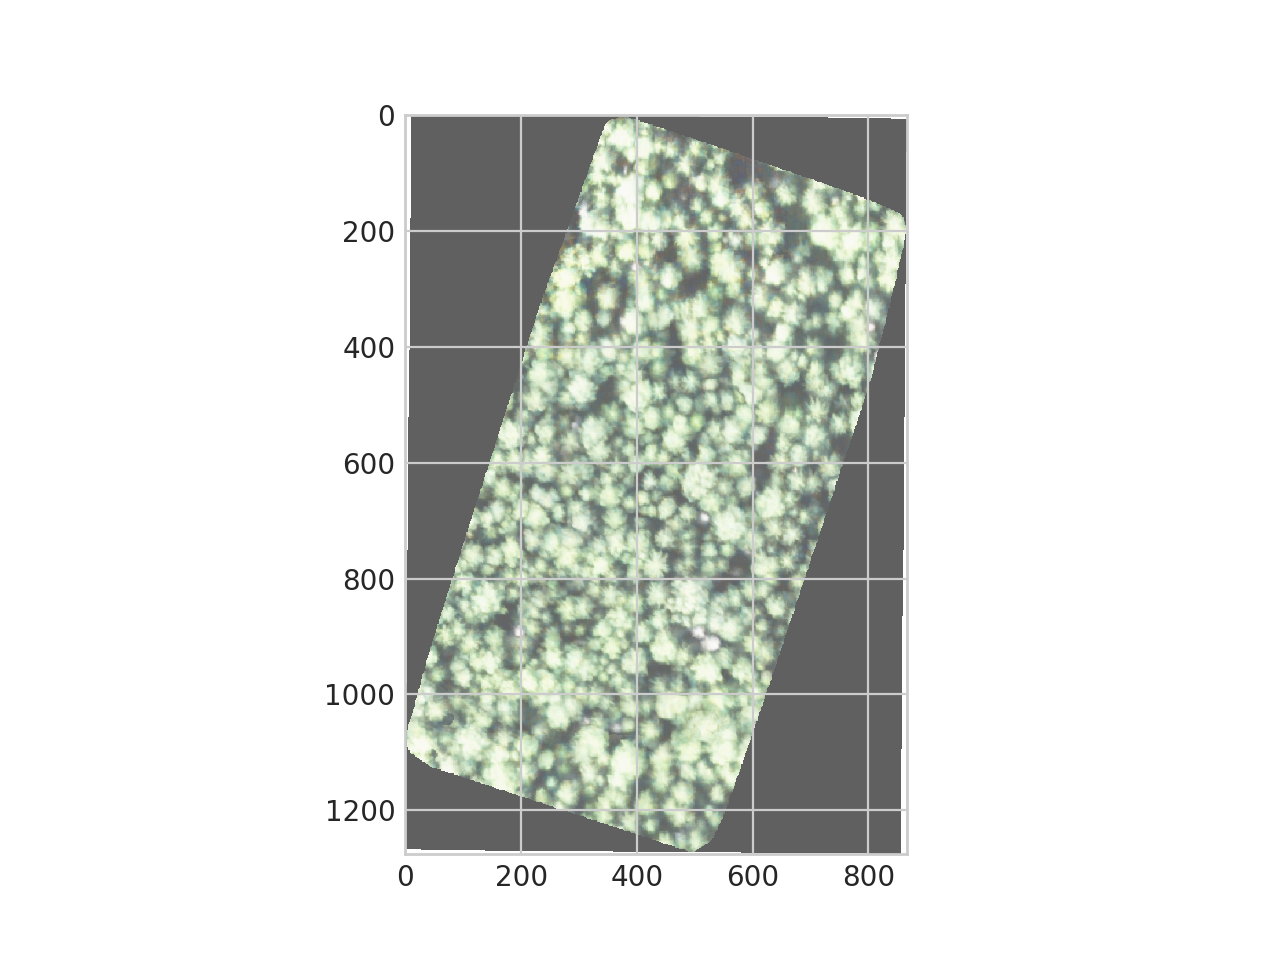

In [402]:
display_image = equalize_hist(np.stack((out_image[14]/65535,out_image[10]/65535,out_image[1]/65535),axis=2))

plt.imshow(display_image)
plt.show()

In [9]:
from scripts.thresholding_watershed import itcd as itcd_tw
from scripts.to_shapefile import crowns_segments

In [363]:
polys = itcd_tw(out_image[0], smoothing=4, min_distance=6, thres_coef=0.5)
n_trees = np.max(polys)
print(n_trees)

559


<IPython.core.display.Javascript object>


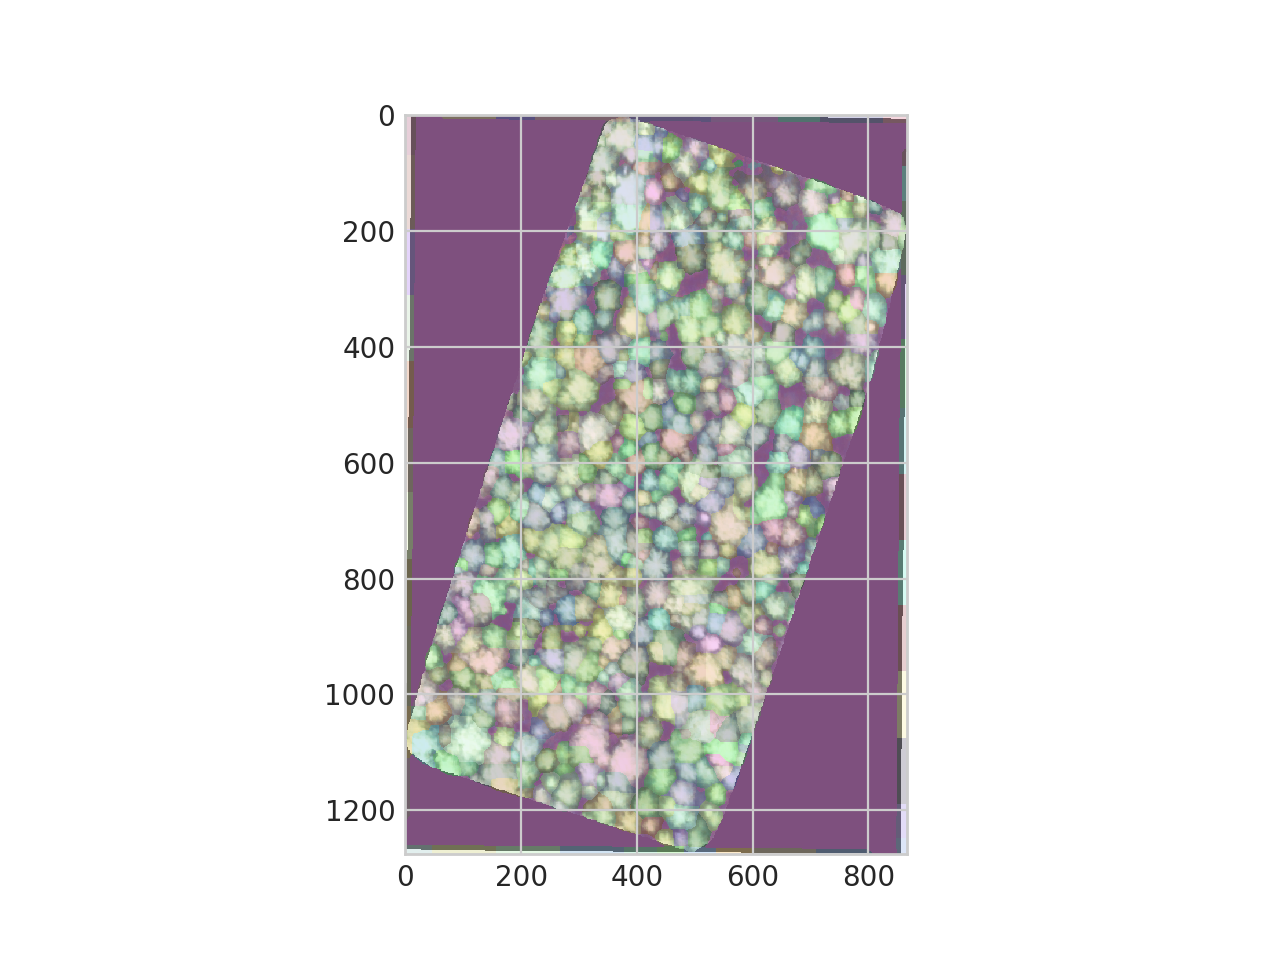

In [364]:
cmap = clr.ListedColormap(np.random.rand(16000,3))

plt.imshow(display_image)
plt.imshow(polys, cmap=cmap, alpha=0.2)
plt.show()

In [365]:
trees_polys = [np.where(polys==i) for i in range(1,np.max(polys)+1)]

<IPython.core.display.Javascript object>


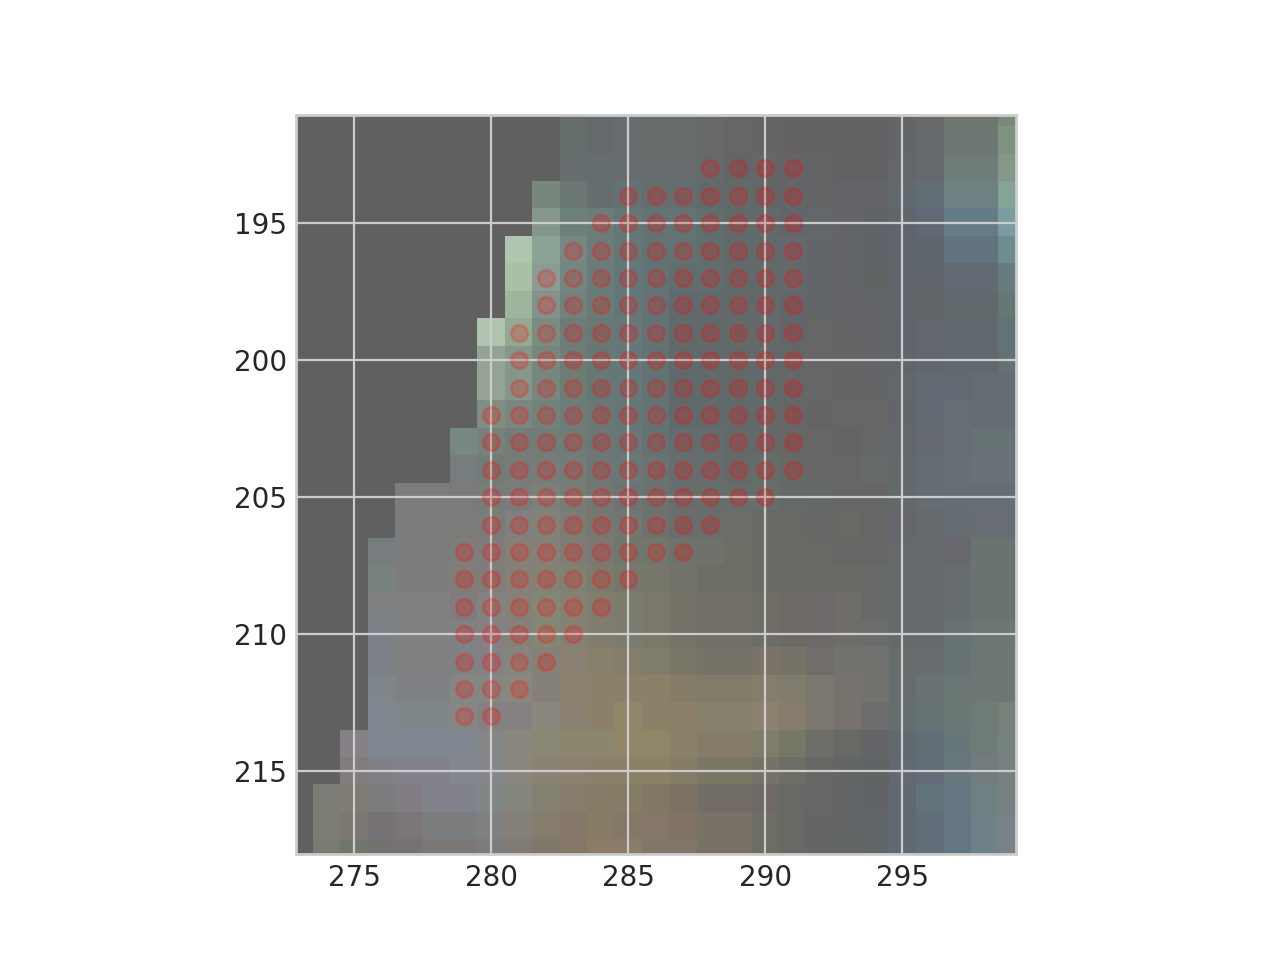

In [366]:
tree_id = 67

plt.imshow(display_image)
plt.scatter(trees_polys[tree_id][1], trees_polys[tree_id][0], alpha=0.2, c='r')
plt.show()

<IPython.core.display.Javascript object>


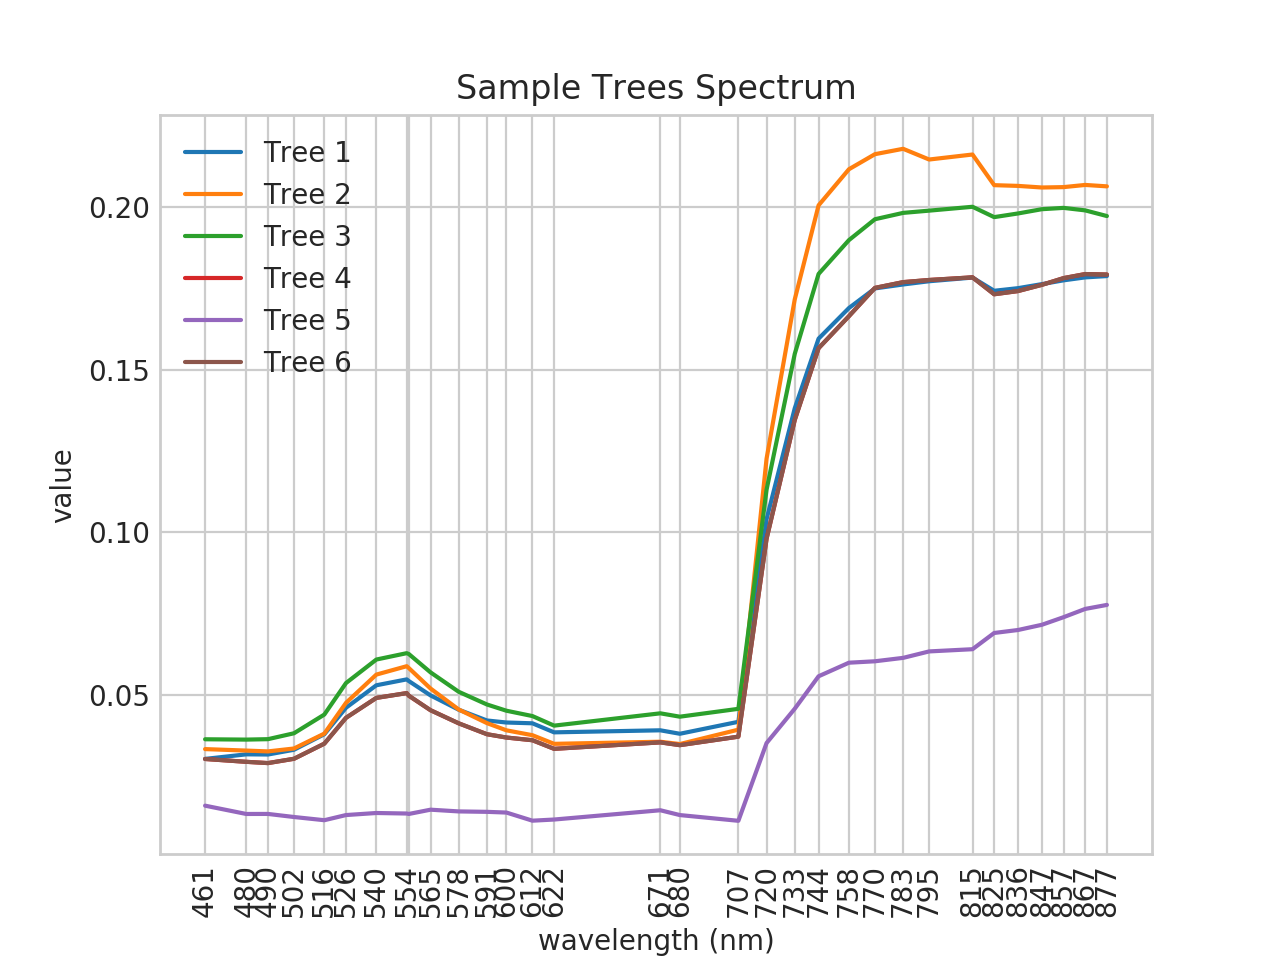

In [367]:
plt.plot(BANDS, np.mean(out_image[:,trees_polys[33][0],trees_polys[33][1]],axis=1)/65535, label='Tree 1')
plt.plot(BANDS, np.mean(out_image[:,trees_polys[226][0],trees_polys[226][1]],axis=1)/65535, label='Tree 2')
plt.plot(BANDS, np.mean(out_image[:,trees_polys[133][0],trees_polys[133][1]],axis=1)/65535, label='Tree 3')
plt.plot(BANDS, np.mean(out_image[:,trees_polys[26][0],trees_polys[26][1]],axis=1)/65535, label='Tree 4')
plt.plot(BANDS, np.mean(out_image[:,trees_polys[67][0],trees_polys[67][1]],axis=1)/65535, label='Tree 5')
plt.plot(BANDS, np.mean(out_image[:,trees_polys[26][0],trees_polys[26][1]],axis=1)/65535, label='Tree 6')
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('value')
plt.title('Sample Trees Spectrum')
plt.show()

# Features Calculation

In [368]:
mean_spectra = [np.mean(out_image[:,trees_polys[i][0],trees_polys[i][1]],axis=1)/65535 for i in range(np.max(polys))]

In [369]:
median_spectra = [np.median(out_image[:,trees_polys[i][0],trees_polys[i][1]],axis=1)/65535 for i in range(n_trees)]

In [370]:
features = np.concatenate((mean_spectra,median_spectra), axis=1)

In [371]:
features_std = scale(features)

<IPython.core.display.Javascript object>


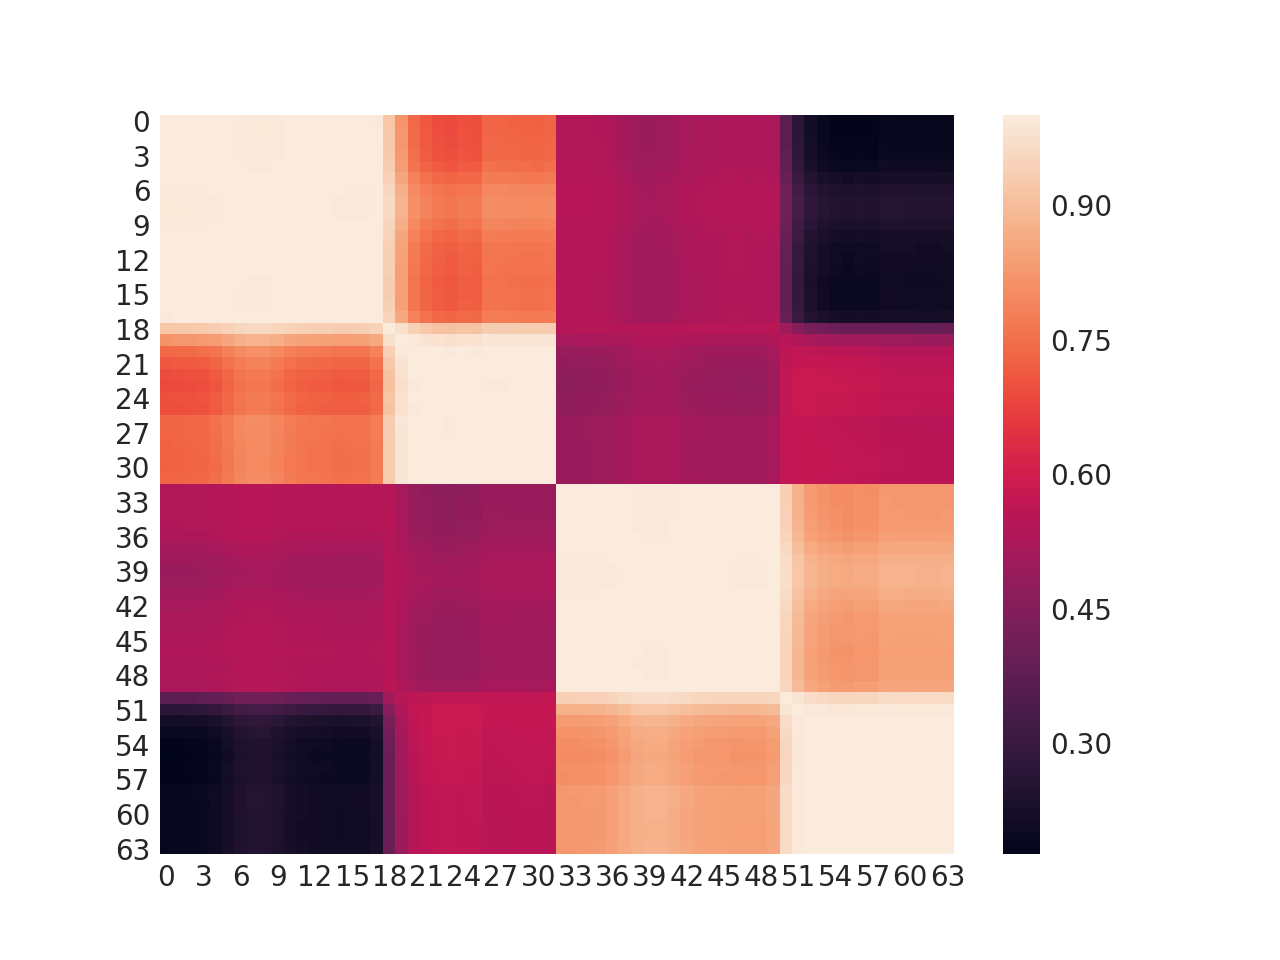

In [372]:
sns.heatmap(pd.DataFrame(features).corr())
plt.show()

# Clustering

In [373]:
pca = PCA(n_components=2)

In [376]:
features_pca = pca.fit_transform(features)

<IPython.core.display.Javascript object>


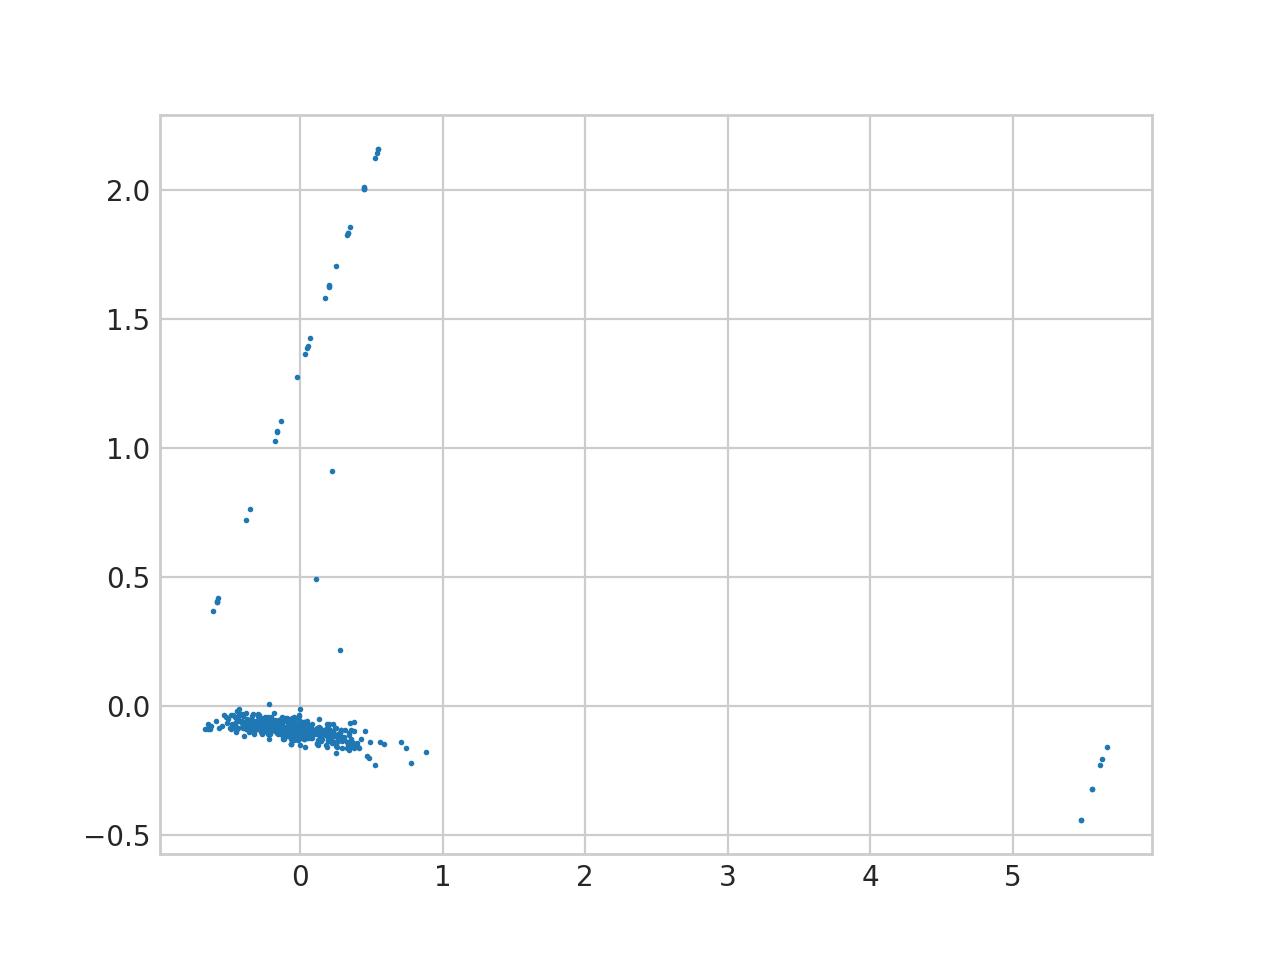

In [377]:
plt.scatter(features_pca[:,0], features_pca[:,1], s=1)
plt.show()

In [380]:
tsne = TSNE(n_components=2)
features_tsne = tsne.fit_transform(features)

<IPython.core.display.Javascript object>


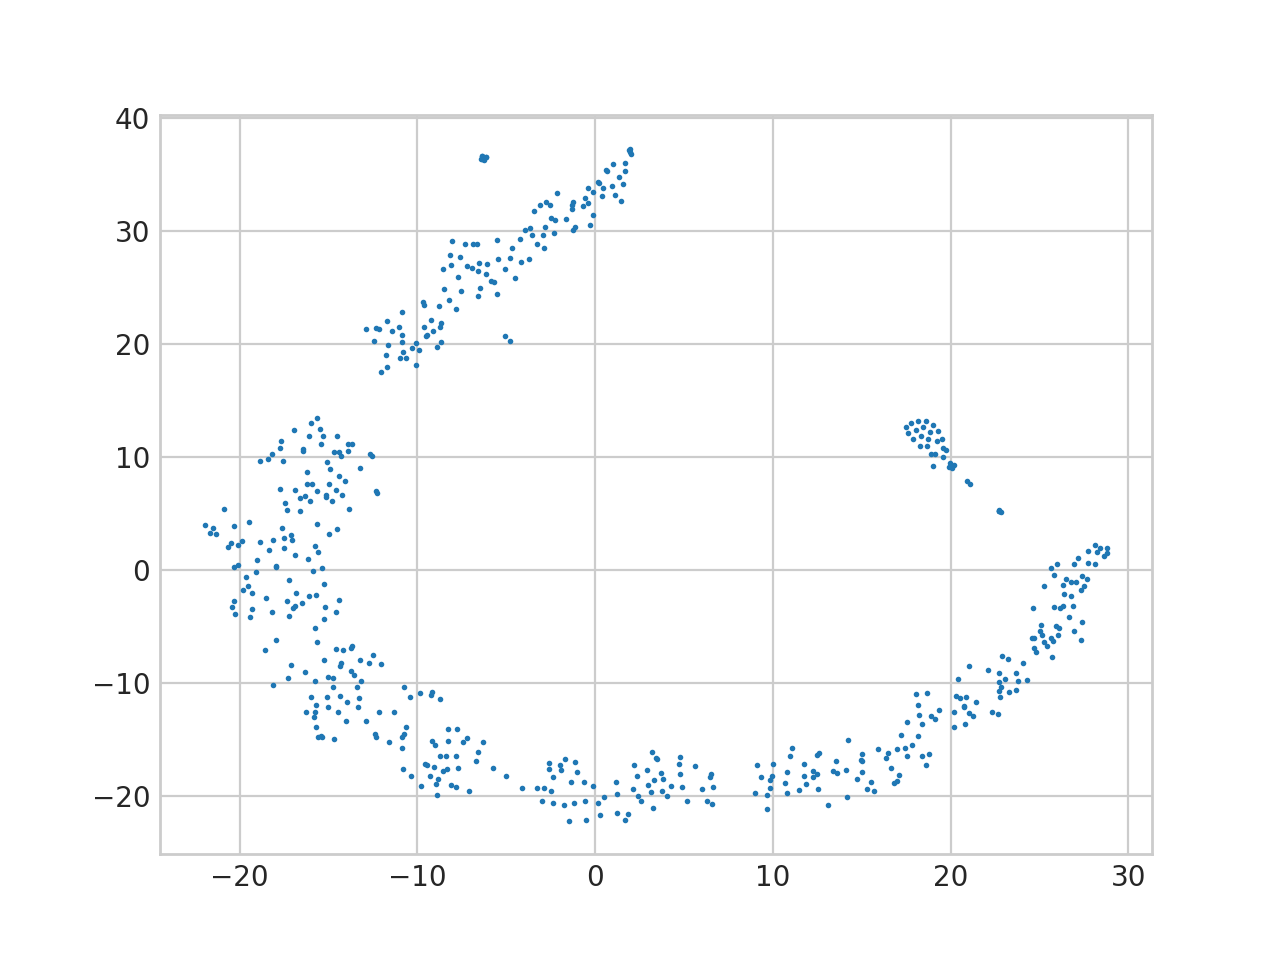

In [381]:
plt.scatter(features_tsne[:,0], features_tsne[:,1], s=1)
plt.show()

In [383]:
kpca = KernelPCA(n_components=2, kernel="poly")
features_kpca = kpca.fit_transform(features)

<IPython.core.display.Javascript object>


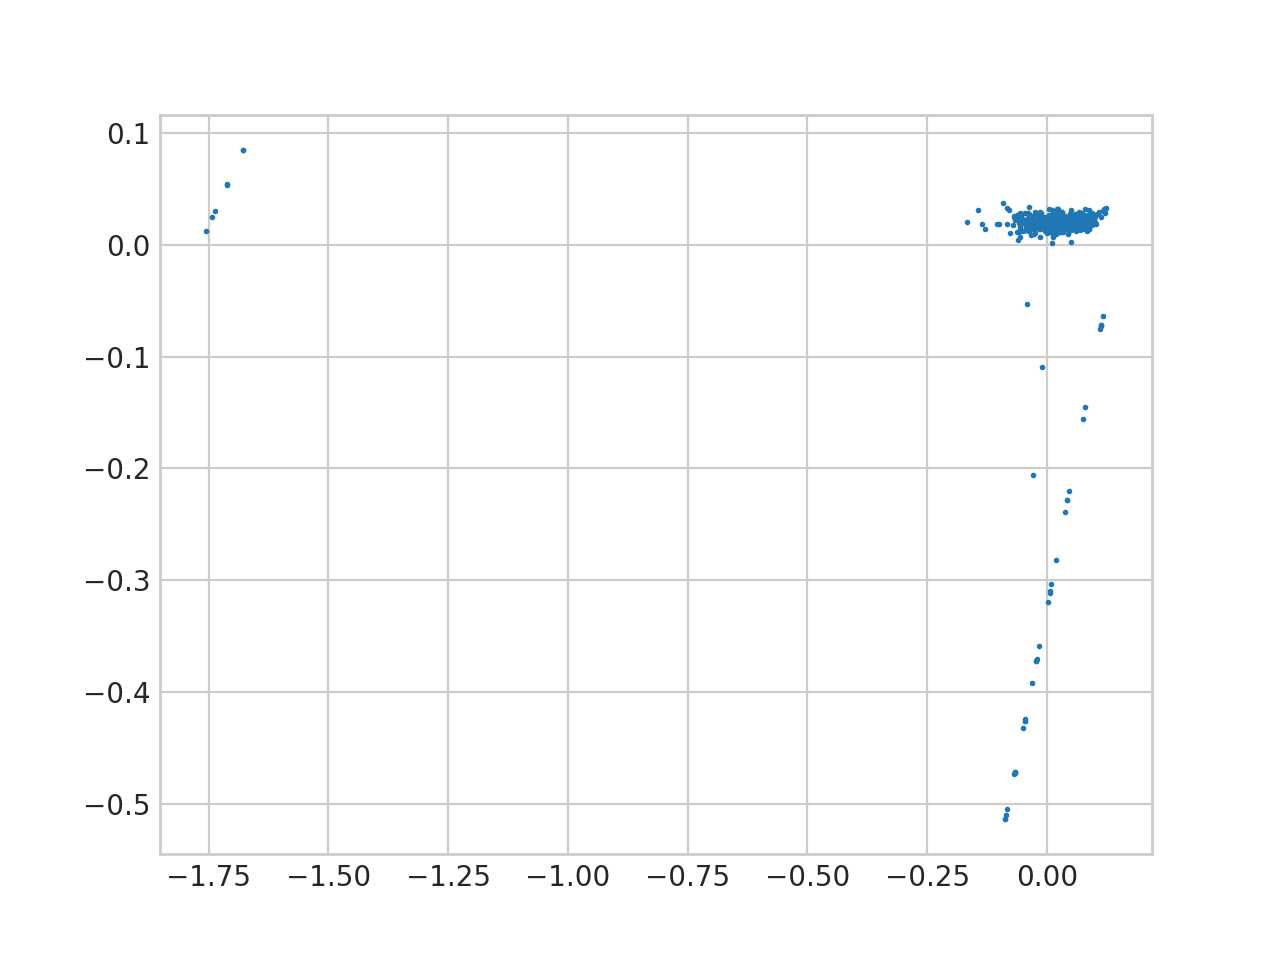

In [384]:
plt.scatter(features_kpca[:,0], features_kpca[:,1], s=1)
plt.show()

In [390]:
clustering = KMeans(n_clusters=4)
clusters = clustering.fit_predict(features)

print(silhouette_score(features, clusters))

0.5290093694507788


In [386]:
clustering = SpectralClustering(n_clusters=3)
clusters = clustering.fit_predict(features)

print(silhouette_score(features, clusters))

0.7906535342874185


<IPython.core.display.Javascript object>


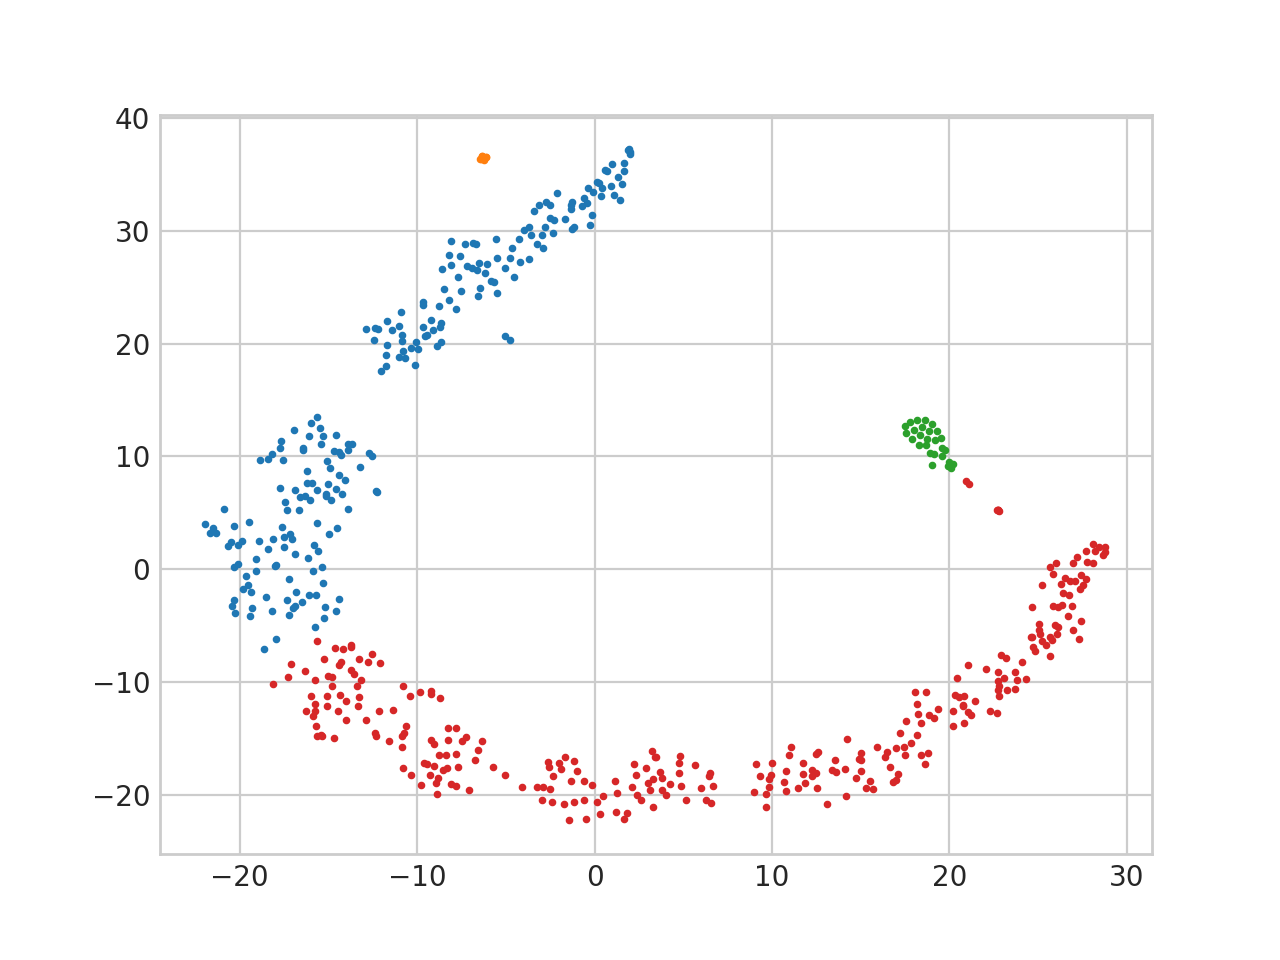

In [391]:
for i in range(44):
    plt.scatter(features_tsne[np.where(clusters==i),0], features_tsne[np.where(clusters==i),1], s=3)
plt.show()

In [395]:
attr_hyper = {'cluster': ('int', [int(c) for c in clusters])}

In [396]:
crowns_segments('./test_shape/shape_01', polys, dst, attr=attr_hyper)

# Calculate Statistics

In [392]:
diameters[int(len(diameters)*0.55)]

17.9

In [393]:
diameters = sorted([i['properties']['d'] for i in shapefile.values()])

In [258]:
grid = fiona.open("../data/shapes/reprojected/pp_2_trees_greed.shp", "r")

In [394]:
richness_shapefile = {}

for gk in grid.keys():
    cell = shapely.geometry.shape(grid[gk]['geometry'])
    cur_richness = []
    for sk in shapefile.keys():
        point = shapely.geometry.shape(shapefile[sk]['geometry'])
        if point.within(cell):
            if shapefile[sk]['properties']['d'] > 17.9:
                cur_richness.append(shapefile[sk]['properties']['specie'])
    richness_shapefile[gk] = len(set(cur_richness))

In [398]:
results = fiona.open("./test_shape/shape_01/shape_01.shp", "r")

In [399]:
richness_results = {}

for gk in grid.keys():
    cell = shapely.geometry.shape(grid[gk]['geometry'])
    cur_richness = []
    for rk in results.keys():
        cur_tree = shapely.geometry.shape(results[rk]['geometry'])
        if cur_tree.intersects(cell):
            cur_richness.append(results[rk]['properties']['cluster'])
    richness_results[gk] = len(set(cur_richness))

In [400]:
non_zero = [k for k in richness_shapefile.keys() if richness_shapefile[k]!=0]

In [401]:
pearsonr([richness_shapefile[k] for k in non_zero],[richness_results[k] for k in non_zero])

(-0.458189794952657, 0.0005604655000800066)